In [543]:
import requests
from datetime import datetime, timedelta
import pandas as pd
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt

In [3]:
import plotly.offline as offline
import plotly.graph_objs as go

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [142]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
pd.set_option('display.expand_frame_repr', False)

## Constant

In [5]:
HEADERS = {
    'accept': 'application/json',
    'fKey' : 'CtUxYST/glqng8QO7P+A2rPaoRwzGmYZCtnWN5z/io9Ng0NP5BrPoiQ6Q9SI1P1KGV7gzquTca2qBsz31vVTDQ=='
}

In [6]:
facilityId = 15
dongNo = [1, 2]

In [7]:
growthObj = 'growth'
searchObj = ["root-env", "in-env", "window-control-status", "ext-env", "env-control-status"]  # {nutrient-solution : N/A}, {power-env : 500_Error}

## Get data

In [541]:
def prams_body(_from: str, _to: str, searchObj: str) -> dict:
    _from = [int(x) for x in _from.split('-')]
    _to = [int(x) for x in _to.split('-')]
    fromGreaterThanEqual = datetime(_from[0], _from[1], _from[2]).strftime("%Y-%m-%d %H:%M:%S")
    toLessThan = datetime(_to[0], _to[1], _to[2]).strftime("%Y-%m-%d %H:%M:%S")
    
    if searchObj in ['window-control-status', 'ext-env', 'env-control-status']:
        param_key = 'type1'
    elif searchObj in ['root-env', 'in-env']:
        param_key = 'type2'
    elif searchObj == 'growth':
        param_key = 'growth'
    else:
        print('not found key')
    
    params_body = {
        'growth' : {
            'start': 0,
            'length': 2000, 
            'orderColumnName': "growthAt",
            'order': 'asc',
            'draw': 0,
            'searchColumns[growthAtGreaterThanEqual]': f'{fromGreaterThanEqual}',
            'searchColumns[growthAtLessThan]': f'{toLessThan}'
        },
        'type1' : {
            'start': 0,
            'length': 10080, 
            'orderColumnName': "sensingAt",
            'order': 'asc',
            'draw': 0,
            'searchColumns[sensingAtGreaterThanEqual]': f'{fromGreaterThanEqual}',
            'searchColumns[sensingAtLessThan]': f'{toLessThan}'
        },
        'type2' : {
            'start': 0,
            'length': 10080, 
            'orderColumnName': "sensingAt",
            'order': 'asc',
            'draw': 0,
            'searchColumns[sensorNo]' : 0,
            'searchColumns[sensingAtGreaterThanEqual]': f'{fromGreaterThanEqual}',
            'searchColumns[sensingAtLessThan]': f'{toLessThan}'
        }
    }

    return params_body[param_key]


In [9]:
def gat_api_data(facilityId, dongNo, searchObj: str, _from: str, _to: str):
    url = f"http://222.105.187.66:52324/api/v1/facility/{facilityId}/{searchObj}/{dongNo}"
    data = requests.get(url, headers=HEADERS, params=prams_body(_from, _to, searchObj)).json()['data']

    info = {}
    if searchObj == 'growth':
        info['get'] = ['growthAt', 'facilityId', 'inFacilityId', 'sampleNumber', 'plantLength']
        info['set'] = ['growthAt', 'facilityId', 'inFacilityId', 'sampleNumber', 'plantLength']
    elif searchObj == 'window-control-status':
        info['get'] = ['sensingAt', 'inFacilityId', 'shadingCurtainPosition', 'thermalCurtainPosition', 'innerWindowPosition', 'outsideWindowPosition', 'leftRoofPosition', 'rightRoofPosition']
        info['set'] = ['win_sensingAt', 'inFacilityId', 'win_shadingCurtainPosition', 'win_thermalCurtainPosition', 'win_innerWindowPosition', 'win_outsideWindowPosition', 'win_leftRoofPosition', 'win_rightRoofPosition']
    elif searchObj == 'root-env':
        info['get'] = ['sensingAt', 'inFacilityId', 'temp', 'humidity', 'ec']
        info['set'] = ['root_sensingAt', 'inFacilityId', 'root_temp', 'root_humidity', 'root_ec']
    elif searchObj == 'in-env':
        info['get'] = ['sensingAt', 'inFacilityId', 'temp', 'humidity', 'co2']
        info['set'] = ['in_sensingAt', 'inFacilityId', 'in_temp', 'in_humidity', 'in_co2']
    elif searchObj == 'ext-env':
        info['get'] = ['sensingAt', 'inFacilityId', 'temp', 'humidity', 'windDirection', 'rain', 'solarRadiation', 'cumulativeSolarRadiation']
        info['set'] = ['ext_sensingAt', 'inFacilityId', 'ext_temp', 'ext_humidity', 'extin_windDirection', 'ext_rain', 'ext_solarRadiation', 'ext_cumulativeSolarRadiation']
    elif searchObj == 'env-control-status':
        info['get'] = ['sensingAt', 'inFacilityId', 'cyclePump1', 'cyclePump2', 'airConditioner', 'flowFan', 'exhaustFan', 'spray', 'fumigationEquipment', 'auxLight', 'sprinkler', 'subAirConditioner', 'co2', 'leftRoof', 'rightRoof', 'curtain1', 'curtain2', 'curtain3']
        info['set'] = ['env_sensingAt', 'inFacilityId', 'env_cyclePump1', 'env_cyclePump2', 'env_airConditioner', 'env_flowFan', 'env_exhaustFan', 'env_spray', 'env_fumigationEquipment', 'env_auxLight', 'env_sprinkler', 'env_subAirConditioner', 'env_co2', 'env_leftRoof', 'env_rightRoof', 'env_curtain1', 'env_curtain2', 'env_curtain3']
    
    df = pd.DataFrame(data)[info['get']]
    df = df.rename(columns = {k:v for k, v in zip(info['get'], info['set'])})
    df['date'] = pd.to_datetime(df[info['set'][0]], format='%Y-%m-%d %H:%M:%S')
    df['dongNo'] = dongNo
    
    if searchObj != 'growth':
        df['facilityId'] = facilityId
        return df[['date', 'facilityId', 'dongNo']+info['set']]
    else:
        return df[['date', 'dongNo']+info['set']]

## remove outlier

In [548]:
def SMA(df, col, window=2):
    return df[col].rolling(window=window, min_periods=1).mean()

In [563]:
def EMA(df, col, span=2):
    return df[col].ewm(span=span).mean()

In [544]:
g1_origin = gat_api_data(15, 1, 'growth', '2021-01-01', '2024-03-29')

In [545]:
g2_origin = gat_api_data(15, 2, 'growth', '2021-01-01', '2024-03-29')

In [550]:
# fig = go.Figure()
# ids = sorted(g2_origin.sampleNumber.unique())

# for i in ids:
#     target = g2_origin[g2_origin['sampleNumber']==i]
#     fig.add_trace(go.Scatter(x=target['date'], y=target['plantLength'],
#                              mode='lines+markers',
#                              name='Sample'+str(i)
#                             )
#                  )
# fig.show()

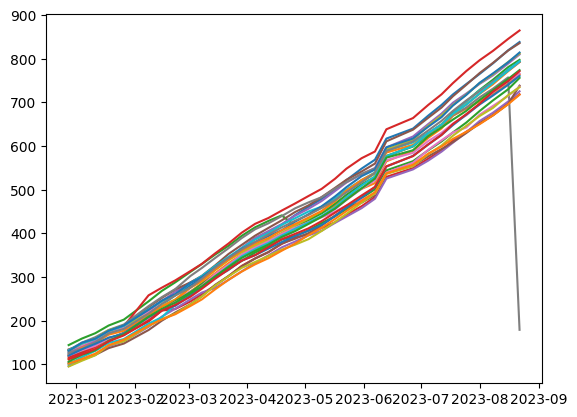

In [552]:
for i in sorted(g1_origin.sampleNumber.unique()):
    target = g1_origin[g1_origin['sampleNumber']==i]
    plt.plot(target['date'], target['plantLength'])

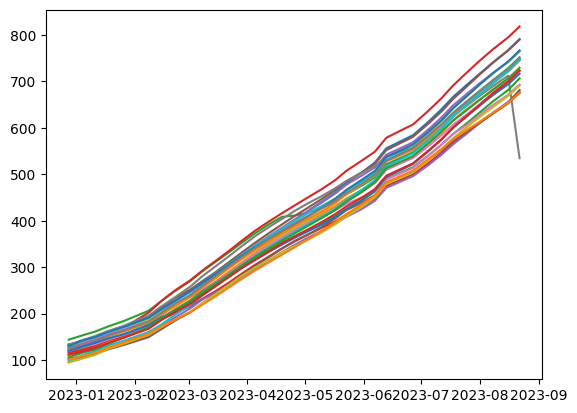

In [566]:
for i in sorted(g1_origin.sampleNumber.unique()):
    target = g1_origin[g1_origin['sampleNumber']==i]
    plt.plot(target['date'], EMA(target, 'plantLength', 5))

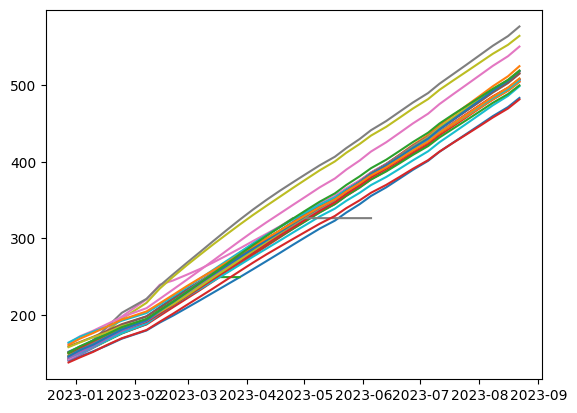

In [571]:
for i in sorted(g2_origin.sampleNumber.unique()):
    target = g2_origin[g2_origin['sampleNumber']==i]
    plt.plot(target['date'], EMA(target, 'plantLength', 120))

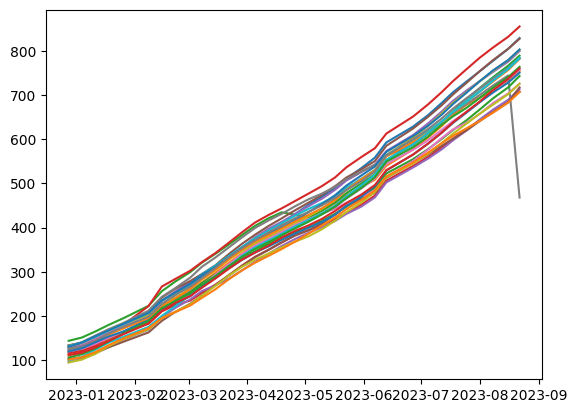

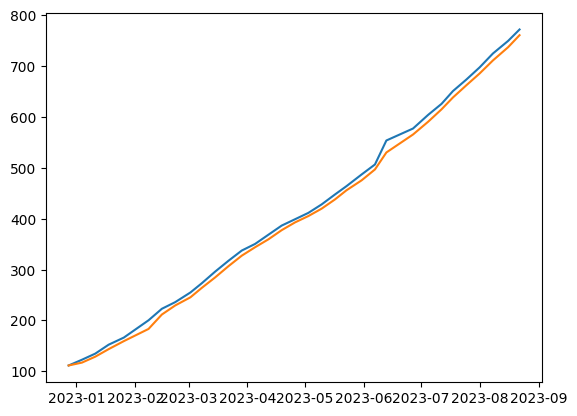

In [536]:
plt.plot(target['date'], target['plantLength'])
plt.plot(target['date'], SMA(target, 'plantLength', window=2))

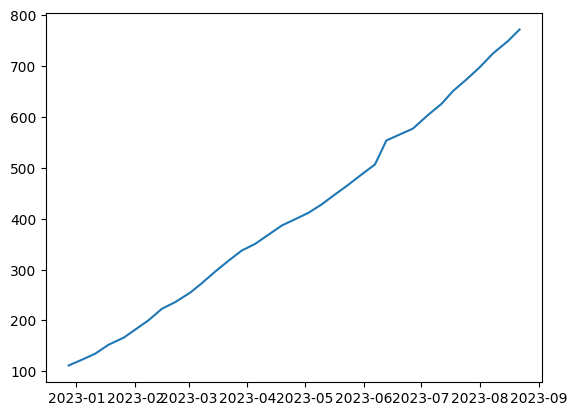

In [455]:
reconstructed_signal

array([111.5+1.37802228e-14j, 122.8-3.74340626e-14j,
       134.8+1.50412007e-14j, 152.3+6.37848572e-15j,
       166.3+2.63993641e-14j, 200.3+4.80351939e-14j,
       222.9-1.54376186e-14j, 235.9-4.99352845e-14j,
       254.9-3.11919710e-14j, 273.1+2.37093503e-14j,
       295.9-5.99296160e-15j, 317.2-2.01490914e-14j,
       337.3+5.73597229e-15j, 350.3+2.77715777e-16j,
       368.4+7.82144504e-16j, 386.4-1.86675808e-14j,
       398.8-1.10974638e-14j, 411.3+7.36646061e-15j,
       428. -2.41581369e-15j, 447.5+2.19940960e-14j,
       463.7-8.64644190e-15j, 486.8+3.68186243e-14j,
       506.4+2.10358717e-14j, 553.5-9.12806763e-15j,
       577. +3.58209162e-15j, 604. -5.60567836e-15j,
       625.5-3.53208334e-14j, 650.6-2.79504467e-14j,
       673.1+1.75250634e-14j, 697.1+4.90747487e-14j,
       724.4+1.23623254e-14j, 749.2-2.89330296e-14j,
       771.6-1.99258625e-15j])

In [149]:
# for i in sorted(g1_origin.sampleNumber.unique()):
#     target = g1_origin[g1_origin['sampleNumber']==i]
#     plt.plot(target['date'], target['plantLength'], '-o')
#     plt.title(str(i))
#     plt.show()

In [147]:
# g1에서 6월 초 이상치 제거 후 재 보간 필요.
    # 이상치인 이유 : 해당 구간이 실제 급성장 구간이였다면, g2에서도 급성장하는 추세가 관측되었어야함.
# g1에서 sample 3은 전체 삭제, sample 8은 마지막 값 제거 하고 재 보간 필요.

# g2에서 sample 7은 전체 삭제, sample 11은 꺽이는값 (약 3주치)제거 하고 재 보간 필요.

# y는 사람이 측정하다 보니 그럴 수 있음
# x는 측정오차가 없을까?

### 이상치 제거 for 15-1

In [275]:
g1_origin = gat_api_data(15, 1, 'growth', '2021-01-01', '2024-03-29')

In [14]:
# 15-1의 6/13 데이터 none 변환
g1_origin.loc[g1_origin['date']=='2023-06-13', 'plantLength'] = None

In [15]:
# sample 8의 마지막 값 제거
g1_origin.drop(g1_origin.loc[(g1_origin['date']=='2023-08-22')&(g1_origin['sampleNumber']==8)].index, inplace=True)

In [16]:
# sample 3 전체 제거
g1_origin.drop(g1_origin.loc[g1_origin['sampleNumber']==3].index, inplace=True)

### 이상치 제거 for 15-2

In [279]:
g2_origin = gat_api_data(15, 2, 'growth', '2021-01-01', '2024-03-29')

In [17]:
# sample 7 전체 제거
g2_origin.drop(g2_origin.loc[g2_origin['sampleNumber']==7].index, inplace=True)

In [18]:
# sample 11의 5/9, 5/17, 5/23 none 변환

In [19]:
g2_origin.loc[(g2_origin['sampleNumber']==11)&(g2_origin['date']>='2023-05-09')&(g2_origin['date']<='2023-05-23'), 'plantLength'] = None

In [20]:
# sample 18의 결측값 제거
g2_origin.drop(g2_origin.loc[(g2_origin['sampleNumber']==18)&(g2_origin['date']>'2023-04-25')].index, inplace=True)

In [21]:
g2_origin.drop(g2_origin.loc[(g2_origin['sampleNumber']==3)&(g2_origin['date']>='2023-03-21')].index, inplace=True)

In [134]:
# for i in sorted(g2_origin.sampleNumber.unique()):
#     target = g2_origin[g2_origin['sampleNumber']==i]
#     plt.plot(target['date'], target['plantLength'], label=str(i))
#     #plt.legend(bbox_to_anchor=(1,1))

## upsampling_y

In [22]:
def upsampling_growth(y):
    con_list = []
    for i in y.sampleNumber.unique():
        # upsampling
        up_g = y[y['sampleNumber']==i]
        up_g = up_g.set_index(keys='date')
        up_g = up_g.resample(rule='1min').last() #Y, M, D, H, T(min), S

        # fill
        cols = ['dongNo', 'growthAt', 'facilityId', 'inFacilityId', 'sampleNumber']
        up_g.loc[:,cols] = up_g.loc[:,cols].bfill()
        up_g = up_g.interpolate(method='time')

        up_g = up_g.astype({'dongNo':'int', 'facilityId':'int', 'inFacilityId':'int', 'sampleNumber':'int'})

        con_list.append(up_g)
    return pd.concat(con_list)

### for 15-1

In [23]:
g1 = g1_origin.copy()
g1 = upsampling_growth(g1)
g1[g1['sampleNumber']==1].head()

,dongNo,growthAt,facilityId,inFacilityId,sampleNumber,plantLength
date,,,,,,
2022-12-28 00:00:00,1,2022-12-28 00:00:00,15,34,1,124.000000
2022-12-28 00:01:00,1,2023-01-04 00:00:00,15,34,1,124.000387
2022-12-28 00:02:00,1,2023-01-04 00:00:00,15,34,1,124.000774
2022-12-28 00:03:00,1,2023-01-04 00:00:00,15,34,1,124.001161
2022-12-28 00:04:00,1,2023-01-04 00:00:00,15,34,1,124.001548


### for 15-2

In [24]:
g2 = g2_origin.copy()
g2 = upsampling_growth(g2)
g2[g2['sampleNumber']==1].head()

,dongNo,growthAt,facilityId,inFacilityId,sampleNumber,plantLength
date,,,,,,
2022-12-28 00:00:00,2,2022-12-28 00:00:00,15,35,1,140.500000
2022-12-28 00:01:00,2,2023-01-03 00:00:00,15,35,1,140.501227
2022-12-28 00:02:00,2,2023-01-03 00:00:00,15,35,1,140.502454
2022-12-28 00:03:00,2,2023-01-03 00:00:00,15,35,1,140.503681
2022-12-28 00:04:00,2,2023-01-03 00:00:00,15,35,1,140.504907


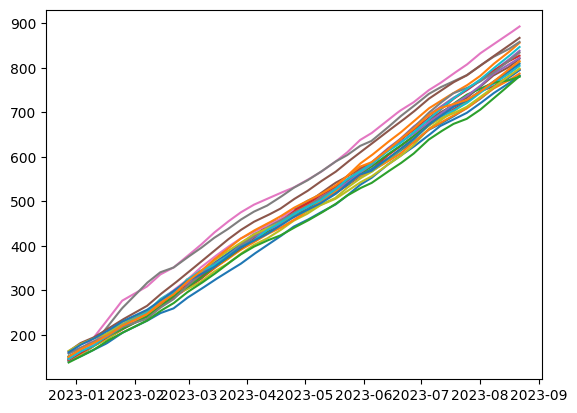

In [287]:
for i in sorted(g2.sampleNumber.unique()):
    target = g2[g2['sampleNumber']==i]
    plt.plot(target.index, target['plantLength'])
    # plt.legend(bbox_to_anchor=(1,1))

In [288]:
# for i in sorted(g2.sampleNumber.unique()):
#     target = g2[g2['sampleNumber']==i]
#     plt.plot(target.index, target['plantLength'])
#     plt.title(str(i))
#     plt.show()
#     # plt.legend(bbox_to_anchor=(1,1))

In [25]:
g1[g1['sampleNumber']==1]

,dongNo,growthAt,facilityId,inFacilityId,sampleNumber,plantLength
date,,,,,,
2022-12-28 00:00:00,1,2022-12-28 00:00:00,15,34,1,124.000000
2022-12-28 00:01:00,1,2023-01-04 00:00:00,15,34,1,124.000387
2022-12-28 00:02:00,1,2023-01-04 00:00:00,15,34,1,124.000774
2022-12-28 00:03:00,1,2023-01-04 00:00:00,15,34,1,124.001161
2022-12-28 00:04:00,1,2023-01-04 00:00:00,15,34,1,124.001548
...,...,...,...,...,...,...
2023-08-21 23:56:00,1,2023-08-22 00:00:00,15,34,1,838.391204
2023-08-21 23:57:00,1,2023-08-22 00:00:00,15,34,1,838.393403
2023-08-21 23:58:00,1,2023-08-22 00:00:00,15,34,1,838.395602


## resampling_x

In [363]:
base_timestamp = datetime.strptime('2022-12-28 00:00:00', "%Y-%m-%d %H:%M:%S")
sub_from = base_timestamp.strftime("%Y-%m-%d")
#sub_from = (base_timestamp-timedelta(weeks=1)).strftime("%Y-%m-%d")
sub_to = (base_timestamp+timedelta(days=1)).strftime("%Y-%m-%d")

In [364]:
sub_from, sub_to

('2022-12-28', '2022-12-29')

In [ ]:
# for obj in searchObj:
#     print(obj)
    
#     d27 = gat_api_data(15, 2, obj, sub_from, sub_to).set_index(keys='date')
#     print(d27.head()[['facilityId', 'dongNo', [s for s in d27.keys() if 'sensingAt' in s][0]]])

In [366]:
for obj in searchObj:
    print(obj)
    
    d27 = gat_api_data(15, 2, obj, sub_from, sub_to).set_index(keys='date').resample(rule='1min').first()
    print(d27.head()[['facilityId', 'dongNo', [s for s in d27.keys() if 'sensingAt' in s][0]]])

root-env
                     facilityId  dongNo       root_sensingAt
date                                                        
2022-12-28 00:00:00          15       2  2022-12-28 00:00:00
2022-12-28 00:01:00          15       2  2022-12-28 00:01:00
2022-12-28 00:02:00          15       2  2022-12-28 00:02:00
2022-12-28 00:03:00          15       2  2022-12-28 00:03:00
2022-12-28 00:04:00          15       2  2022-12-28 00:04:00
in-env
                     facilityId  dongNo         in_sensingAt
date                                                        
2022-12-28 00:00:00          15       2  2022-12-28 00:00:00
2022-12-28 00:01:00          15       2  2022-12-28 00:01:00
2022-12-28 00:02:00          15       2  2022-12-28 00:02:00
2022-12-28 00:03:00          15       2  2022-12-28 00:03:00
2022-12-28 00:04:00          15       2  2022-12-28 00:04:00
window-control-status
                     facilityId  dongNo        win_sensingAt
date                                           

## insert each measurments

### conn

In [28]:
db = InfluxDBClient('localhost', 8086, 'admin', 'admin', 'RDA_DB')

### query example

In [32]:
# Explore
# pd.DataFrame(db.query('show measurements').get_points())
# pd.DataFrame(db.query('show tag keys from {measurements_name}').get_points())
# pd.DataFrame(db.query('show field keys from {measurements_name}').get_points())
# pd.DataFrame(db.query('show tag values from {measurements_name} with key = {key_name}').get_points())

In [37]:
# dataframe
pd.DataFrame(db.query("select * from growth where dongNo = '1' and sampleNumber='1' order by desc limit 10").get_points())

,time,dongNo,facilityId,growthAt,inFacilityId,plantLength,sampleNumber
0,2023-08-22T00:00:00Z,1,15,2023-08-22 00:00:00,34,838.400000,1
1,2023-08-21T23:59:00Z,1,15,2023-08-22 00:00:00,34,838.397801,1
2,2023-08-21T23:58:00Z,1,15,2023-08-22 00:00:00,34,838.395602,1
3,2023-08-21T23:57:00Z,1,15,2023-08-22 00:00:00,34,838.393403,1
4,2023-08-21T23:56:00Z,1,15,2023-08-22 00:00:00,34,838.391204,1
5,2023-08-21T23:55:00Z,1,15,2023-08-22 00:00:00,34,838.389005,1
6,2023-08-21T23:54:00Z,1,15,2023-08-22 00:00:00,34,838.386806,1
7,2023-08-21T23:53:00Z,1,15,2023-08-22 00:00:00,34,838.384606,1
8,2023-08-21T23:52:00Z,1,15,2023-08-22 00:00:00,34,838.382407,1
9,2023-08-21T23:51:00Z,1,15,2023-08-22 00:00:00,34,838.380208,1


In [34]:
# dict, if want loop then change type to dict.
pd.DataFrame(db.query('select * from growth limit 3').get_points()).to_dict('records')

[{'time': '2022-12-28T00:00:00Z',
  'dongNo': '1',
  'facilityId': '15',
  'growthAt': '2022-12-28 00:00:00',
  'inFacilityId': '34',
  'plantLength': 124.0,
  'sampleNumber': '1'},
 {'time': '2022-12-28T00:00:00Z',
  'dongNo': '1',
  'facilityId': '15',
  'growthAt': '2022-12-28 00:00:00',
  'inFacilityId': '34',
  'plantLength': 132.0,
  'sampleNumber': '10'},
 {'time': '2022-12-28T00:00:00Z',
  'dongNo': '1',
  'facilityId': '15',
  'growthAt': '2022-12-28 00:00:00',
  'inFacilityId': '34',
  'plantLength': 121.5,
  'sampleNumber': '12'}]

### insert format

In [78]:
def make_body(result, obj):
    result_body = []
    result = result.reset_index()
    result_dict = result.to_dict('records')

    meas_name = {
        "root-env" : "rootEnv",
        "in-env" : "inEnv",
        "window-control-status" : "windowControlStatus",
        "ext-env" : "extEnv",
        "env-control-status" : "envControlStatus"
    }
    
    for r_row in result_dict:
        body = {
            "measurement": meas_name[obj],
            "tags": {k:v for k,v in r_row.items() if k in ['facilityId', 'dongNo', 'inFacilityId']} if obj!='growth' \
                    else {k:v for k,v in r_row.items() if k in ['facilityId', 'inFacilityId', 'dongNo', 'sampleNumber']},
            "time": r_row['date'].strftime('%Y-%m-%dT%H:%M:%SZ'),
            "fields": {k:v for k,v in r_row.items() if k not in ['date', 'facilityId', 'dongNo', 'inFacilityId']} if obj!='growth' \
                      else {k:v for k,v in r_row.items() if k not in ['date', 'facilityId', 'inFacilityId', 'dongNo', 'sampleNumber']}
        }
        result_body.append(body)
        
    return result_body

In [439]:
make_body(g1.iloc[:10], 'growth')

[{'measurement': 'growth',
  'tags': {'dongNo': 1,
   'facilityId': 15,
   'inFacilityId': 34,
   'sampleNumber': 2},
  'time': '2022-12-28T00:00:00Z',
  'fields': {'growthAt': '2022-12-28 00:00:00', 'plantLength': 112.0}},
 {'measurement': 'growth',
  'tags': {'dongNo': 1,
   'facilityId': 15,
   'inFacilityId': 34,
   'sampleNumber': 2},
  'time': '2022-12-28T00:01:00Z',
  'fields': {'growthAt': '2023-01-04 00:00:00',
   'plantLength': 112.00150793650793}},
 {'measurement': 'growth',
  'tags': {'dongNo': 1,
   'facilityId': 15,
   'inFacilityId': 34,
   'sampleNumber': 2},
  'time': '2022-12-28T00:02:00Z',
  'fields': {'growthAt': '2023-01-04 00:00:00',
   'plantLength': 112.00301587301587}},
 {'measurement': 'growth',
  'tags': {'dongNo': 1,
   'facilityId': 15,
   'inFacilityId': 34,
   'sampleNumber': 2},
  'time': '2022-12-28T00:03:00Z',
  'fields': {'growthAt': '2023-01-04 00:00:00',
   'plantLength': 112.0045238095238}},
 {'measurement': 'growth',
  'tags': {'dongNo': 1,
   'fa

In [442]:
# gg1 = make_body(g1, 'growth')

In [443]:
# gg2 = make_body(g2, 'growth')

In [444]:
# db.write_points(gg1, batch_size=1000)

True

In [445]:
# db.write_points(gg2, batch_size=1000)

True

In [236]:
searchObj

['root-env',
 'in-env',
 'window-control-status',
 'ext-env',
 'env-control-status']

In [247]:
def insert_x():
    for dong in dongNo:
        for obj in searchObj:
            for time_idx in pd.date_range(start='2022-12-20', end='2023-08-23', freq='D'):
                sub_from = time_idx.strftime("%Y-%m-%d")
                sub_to = (time_idx+timedelta(days=1)).strftime("%Y-%m-%d")
                
                range_x = gat_api_data(15, dong, obj, sub_from, sub_to).set_index(keys='date').resample(rule='1min').first().dropna()
                range_x = range_x.astype({'dongNo':'int', 'facilityId':'int', 'inFacilityId':'int'})
                if obj == 'ext-env':
                    range_x = range_x.astype({'ext_rain':'bool'})
                elif obj == 'env-control-status':
                    params = ['env_cyclePump1', 'env_cyclePump2', 'env_airConditioner', 'env_flowFan', 'env_exhaustFan', 'env_spray', 'env_fumigationEquipment', 'env_auxLight', 'env_sprinkler', 'env_subAirConditioner', 'env_co2', 'env_leftRoof', 'env_rightRoof', 'env_curtain1', 'env_curtain2', 'env_curtain3']
                    bools = ['bool' for x in params]
                    range_x = range_x.astype({k:v for k,v in zip(params, bools)})
                
                x_body = make_body(range_x, obj)
                stat = db.write_points(x_body, batch_size=1440)
                
                if stat:
                    print(f'processed {dong}-dong, {obj}, {sub_from}, {sub_to}')
                else: 
                    raise Exception(f'insert error at : {dong}-dong, {obj}, {sub_from}, {sub_to}')

In [246]:
insert_x()

processed 1-dong, in-env, 2022-12-20, 2022-12-21
processed 1-dong, in-env, 2022-12-21, 2022-12-22
processed 1-dong, in-env, 2022-12-22, 2022-12-23
processed 1-dong, in-env, 2022-12-23, 2022-12-24
processed 1-dong, in-env, 2022-12-24, 2022-12-25
processed 1-dong, in-env, 2022-12-25, 2022-12-26
processed 1-dong, in-env, 2022-12-26, 2022-12-27
processed 1-dong, in-env, 2022-12-27, 2022-12-28
processed 1-dong, in-env, 2022-12-28, 2022-12-29
processed 1-dong, in-env, 2022-12-29, 2022-12-30
processed 1-dong, in-env, 2022-12-30, 2022-12-31
processed 1-dong, in-env, 2022-12-31, 2023-01-01
processed 1-dong, in-env, 2023-01-01, 2023-01-02
processed 1-dong, in-env, 2023-01-02, 2023-01-03
processed 1-dong, in-env, 2023-01-03, 2023-01-04
processed 1-dong, in-env, 2023-01-04, 2023-01-05
processed 1-dong, in-env, 2023-01-05, 2023-01-06
processed 1-dong, in-env, 2023-01-06, 2023-01-07
processed 1-dong, in-env, 2023-01-07, 2023-01-08
processed 1-dong, in-env, 2023-01-08, 2023-01-09
processed 1-dong, in

## insert integrated measurement

In [ ]:
select * from extEnv where time >= '2022-12-28' and time < '2022-12-29' and dongNo = '1'

In [155]:
aa = pd.DataFrame(db.query("select * from growth where time >= '2022-12-28' and time < '2022-12-29' and dongNo = '1' and sampleNumber='1'").get_points()).set_index(keys='time')

In [212]:
pd.date_range(start='2022-12-28', end='2023-08-23', freq='D')

DatetimeIndex(['2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31',
               '2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06',
               ...
               '2023-08-14', '2023-08-15', '2023-08-16', '2023-08-17',
               '2023-08-18', '2023-08-19', '2023-08-20', '2023-08-21',
               '2023-08-22', '2023-08-23'],
              dtype='datetime64[ns]', length=239, freq='D')

In [255]:
samples = pd.DataFrame(db.query(f"show tag values from growth with key=sampleNumber where dongNo='{dong}'").get_points())['value'].tolist()

In [256]:
samples

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [ ]:
for time_idx in pd.date_range(start='2022-12-28', end='2023-08-23', freq='D'):

In [366]:
def get_x(regex, meas, sub_from, sub_to, dong):
    query_x = f"select {regex} from {meas} where time >= '{sub_from}' and time < '{sub_to}' and dongNo = '{dong}'"
    temp_x = pd.DataFrame(db.query(query_x).get_points())
    temp_x['time'] = pd.to_datetime(temp_x['time'], format='%Y-%m-%dT%H:%M:%SZ')
    
    return temp_x.set_index(keys='time')

def get_y(sub_from, sub_to, dong, sample):
    query_y = f"select * from growth where time >= '{sub_from}' and time < '{sub_to}' and dongNo = '{dong}' and sampleNumber='{sample}'"
    temp_y = pd.DataFrame(db.query(query_y).get_points())
    temp_y['time'] = pd.to_datetime(temp_y['time'], format='%Y-%m-%dT%H:%M:%SZ')
    
    return temp_y.set_index(keys='time')

In [395]:
def make_body_integrated(result, rule='origin'):
    meas_name = 'GreenHouse'
    variation = {'origin':'_1m', '30min':'_30m', '1h':'_1h', '3h':'_3h', '6h':'_6h', '12h':'_12h', '1d':'_1d'}
    tags = ['facilityId', 'inFacilityId', 'dongNo', 'sampleNumber']
    
    if rule != 'origin':
        result = result.resample(rule=rule).first().dropna()
    
    result_body = []
    result = result.reset_index()
    result_dict = result.to_dict('records')

    for r_row in result_dict:
        body = {
            "measurement": meas_name+variation[rule],
            "tags": {k:v for k,v in r_row.items() if k in tags},
            "time": r_row['time'].strftime('%Y-%m-%dT%H:%M:%SZ'),
            "fields": {k:v for k,v in r_row.items() if k not in tags+['time']}
        }
        result_body.append(body)
        
    return result_body

In [397]:
def insert_integrated():
    searchMeasRegex = {'rootEnv':'/^root_/', 'inEnv':'/^in_/', 'windowControlStatus':'/^win_/', 'extEnv':'/^ext_/', 'envControlStatus':'/^env_/'}
    
    for dong in dongNo:
        samples = pd.DataFrame(db.query(f"show tag values from growth with key=sampleNumber where dongNo='{dong}'").get_points())['value'].tolist()
        samples.sort(key=int)
        
        for sample in samples:
            
            for time_idx in pd.date_range(start='2022-12-28', end='2023-08-22', freq='D'):
                res = []
                sub_from = time_idx.strftime("%Y-%m-%d")
                sub_to = (time_idx+timedelta(days=1)).strftime("%Y-%m-%d")
    
                sets = [get_x(regex, meas, sub_from, sub_to, dong) for meas, regex in searchMeasRegex.items()]
                try:
                    sets.append(get_y(sub_from, sub_to, dong, sample))
                except:
                    continue
                itg_set = pd.concat(sets, axis=1).dropna()

                rules = ['origin', '30min', '1h', '3h', '6h', '12h', '1d']
                [res.append(db.write_points(make_body_integrated(itg_set, rule=r), batch_size=1440)) for r in rules]
                
                if all(res):
                    print(f'processed {dong}-dong, {sample}-sample, {sub_from}, {sub_to}')
                else: 
                    raise Exception(f'insert error at : {dong}-dong, {sample}-sample, {sub_from}, {sub_to}')

In [398]:
insert_integrated()

processed 1-dong, 1-sample, 2022-12-28, 2022-12-29
processed 1-dong, 1-sample, 2022-12-29, 2022-12-30
processed 1-dong, 1-sample, 2022-12-30, 2022-12-31
processed 1-dong, 1-sample, 2022-12-31, 2023-01-01
processed 1-dong, 1-sample, 2023-01-01, 2023-01-02
processed 1-dong, 1-sample, 2023-01-02, 2023-01-03
processed 1-dong, 1-sample, 2023-01-03, 2023-01-04
processed 1-dong, 1-sample, 2023-01-04, 2023-01-05
processed 1-dong, 1-sample, 2023-01-05, 2023-01-06
processed 1-dong, 1-sample, 2023-01-06, 2023-01-07
processed 1-dong, 1-sample, 2023-01-07, 2023-01-08
processed 1-dong, 1-sample, 2023-01-08, 2023-01-09
processed 1-dong, 1-sample, 2023-01-09, 2023-01-10
processed 1-dong, 1-sample, 2023-01-10, 2023-01-11
processed 1-dong, 1-sample, 2023-01-11, 2023-01-12
processed 1-dong, 1-sample, 2023-01-12, 2023-01-13
processed 1-dong, 1-sample, 2023-01-13, 2023-01-14
processed 1-dong, 1-sample, 2023-01-14, 2023-01-15
processed 1-dong, 1-sample, 2023-01-15, 2023-01-16
processed 1-dong, 1-sample, 202

In [383]:
query = "select * from GreenHouse_6h where dongNo='1' and sampleNumber='1' limit 10"

In [384]:
pd.DataFrame(db.query(query).get_points())

,time,dongNo,env_airConditioner,env_auxLight,env_co2,env_curtain1,env_curtain2,env_curtain3,env_cyclePump1,env_cyclePump2,...,root_sensingAt,root_temp,sampleNumber,win_innerWindowPosition,win_leftRoofPosition,win_outsideWindowPosition,win_rightRoofPosition,win_sensingAt,win_shadingCurtainPosition,win_thermalCurtainPosition
0,2022-12-28T00:00:00Z,1,True,False,False,True,True,True,False,False,...,2022-12-28 00:00:00,15.11,1,0.0,0.0,0.0,0.0,2022-12-28 00:00:02,0.0,0.0
1,2022-12-28T00:01:00Z,1,False,False,False,True,True,True,False,False,...,2022-12-28 00:01:00,15.13,1,0.0,0.0,0.0,0.0,2022-12-28 00:01:03,0.0,0.0
2,2022-12-28T00:02:00Z,1,True,False,False,True,True,True,False,False,...,2022-12-28 00:02:00,15.26,1,0.0,0.0,0.0,0.0,2022-12-28 00:02:05,0.0,0.0
3,2022-12-28T00:03:00Z,1,True,False,False,True,True,True,False,False,...,2022-12-28 00:03:00,15.51,1,0.0,0.0,0.0,0.0,2022-12-28 00:03:00,0.0,0.0
4,2022-12-28T00:04:00Z,1,True,False,False,True,True,True,False,False,...,2022-12-28 00:04:00,15.66,1,0.0,0.0,0.0,0.0,2022-12-28 00:04:01,0.0,0.0
5,2022-12-28T00:05:00Z,1,True,False,False,True,True,True,False,False,...,2022-12-28 00:05:00,15.88,1,0.0,0.0,0.0,0.0,2022-12-28 00:05:03,0.0,0.0
6,2022-12-28T00:06:00Z,1,False,False,False,True,True,True,False,False,...,2022-12-28 00:06:00,16.08,1,0.0,0.0,0.0,0.0,2022-12-28 00:06:03,0.0,0.0
7,2022-12-28T00:07:00Z,1,False,False,False,True,True,True,False,False,...,2022-12-28 00:07:00,16.10,1,0.0,0.0,0.0,0.0,2022-12-28 00:07:04,0.0,0.0
8,2022-12-28T00:08:00Z,1,False,False,False,True,True,True,False,False,...,2022-12-28 00:08:00,16.13,1,0.0,0.0,0.0,0.0,2022-12-28 00:08:05,0.0,0.0
9,2022-12-28T00:09:00Z,1,False,False,False,True,True,True,False,False,...,2022-12-28 00:09:00,15.76,1,0.0,0.0,0.0,0.0,2022-12-28 00:09:07,0.0,0.0
